In [1]:
pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 torchtext==0.12.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |████████████████▎               | 834.1 MB 1.3 MB/s eta 0:10:11tcmalloc: large alloc 1147494400 bytes == 0x38c12000 @  0x7fc7a33cc615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |████████████████████▋           | 1055.7 MB 1.3 MB/s eta 0:07:37tcmalloc: large alloc 1434370048 bytes == 0x7d268000 @  0x7fc7a33cc615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x4fd8b5 0x4997c7 0x4fd8b5 0x49abe4 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x4f5fe9 0x55e146 0x5d8868 0x5da092 0x587116 0x5d8d8c 0x55dc1e 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4990ca 0x5d8868 0x4997a2 0x4fd8b5 0x49abe4
     |██████████████████████████▏     | 

In [2]:
import scipy
import torch
import matplotlib.pyplot as plt

In [3]:
# To install Falkon library
!pip install git+https://github.com/falkonml/falkon.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/falkonml/falkon.git to /tmp/pip-req-build-lc5_by4a
  Running command git clone -q https://github.com/falkonml/falkon.git /tmp/pip-req-build-lc5_by4a
  Cloning https://github.com/getkeops/keops (to revision ad044a671fdc3c2790b0321f6b9f9b5aa3d220df) to /tmp/pip-install-khojlai1/keopscore_457c94a4bfd64211b9ce552e2887c358
  Running command git clone -q https://github.com/getkeops/keops /tmp/pip-install-khojlai1/keopscore_457c94a4bfd64211b9ce552e2887c358
  Running command git rev-parse -q --verify 'sha^ad044a671fdc3c2790b0321f6b9f9b5aa3d220df'
  Running command git fetch -q https://github.com/getkeops/keops ad044a671fdc3c2790b0321f6b9f9b5aa3d220df
  Running command git checkout -q ad044a671fdc3c2790b0321f6b9f9b5aa3d220df
  Running command git submodule update --init --recursive -q
  Cloning https://github.com/getkeops/keops (to revision ad044a671fdc3c2790b0321f6b9f

In [4]:
import falkon

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [5]:
# Drive
from google.colab import drive

# we connect to the drive folder to work with the data stored
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd

In [7]:
import os, time

In [24]:
import numpy as np

import os, time

import torch

from falkon import LogisticFalkon
from falkon.kernels import GaussianKernel
from falkon.options import FalkonOptions
from falkon.gsc_losses import WeightedCrossEntropyLoss

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

from sklearn import metrics
from scipy.spatial.distance import pdist
from scipy.stats import norm, chi2, rv_continuous, kstest


# UTILS

def candidate_sigma(data, perc=90):
    # this function estimates the width of the gaussian kernel.
    # use on a (small) sample of reference data (standardize first if necessary)
    pairw = pdist(data)
    return round(np.percentile(pairw,perc),1)

'''
def NP2_gen(size, seed):
    # custom function to generate samples of non-resonant new physics events
    if size>10000:
        raise Warning('Sample size is grater than 1000: Generator will not approximate the tail well')
    sample = np.array([])
    #normalization factor                                                                                                                                    
    np.random.seed(seed)
    Norm = 256.*0.25*0.25*np.exp(-2)
    while(len(sample)<size):
        x = np.random.uniform(0,1) #assuming not to generate more than 10 000 events                                                                         
        p = np.random.uniform(0, Norm)
        if p<= 256.*x*x*np.exp(-8.*x):
            sample = np.append(sample, x)
    return sample
'''

class non_res(rv_continuous):

    def _pdf(self, x):

        return 256 * (x**2) * np.exp(- 8 * x)

def nonres_sig(N_S, seed):
    # this function can be used to generate non-resonant signal events.
    
    my_sig = non_res(momtype = 0, a=0, b=1, seed=seed)
    
    sig_sample = my_sig.rvs(size = N_S)
    
    return sig_sample


def get_logflk_config(M,flk_sigma,lam,weight,iter=[100],seed=None,cpu=False):
    # it returns logfalkon parameters
    return {
            'kernel' : GaussianKernel(sigma=flk_sigma),
            'M' : M, #number of Nystrom centers,
            'penalty_list' : lam, # list of regularization parameters,
            'iter_list' : iter, #list of number of CG iterations,
            'options' : FalkonOptions(cg_tolerance=np.sqrt(1e-7), keops_active='no', use_cpu=cpu, debug = False),
            'seed' : seed, # (int or None), the model seed (used for Nystrom center selection) is manually set,
            'loss' : WeightedCrossEntropyLoss(kernel=GaussianKernel(sigma=flk_sigma), neg_weight=weight),
            }


def compute_t(preds,Y,weight):
    # it returns extended log likelihood ratio from predictions
    diff = weight*np.sum(1 - np.exp(preds[Y==0]))
    return 2 * (diff + np.sum(preds[Y==1]))

def trainer(X,Y,flk_config):
    # trainer for logfalkon model
    Xtorch=torch.from_numpy(X)
    Ytorch=torch.from_numpy(Y)
    model = LogisticFalkon(**flk_config)
    model.fit(Xtorch, Ytorch)
    return model.predict(Xtorch).numpy()

def standardize(X):
    # standardize data as in HIGGS and SUSY
    for j in range(X.shape[1]):
        column = X[:, j]

        mean = np.mean(column)
        std = np.std(column)
    
        if np.min(column) < 0:
            column = (column-mean)*1./ std
        elif np.max(column) > 1.0:                                                                                                                                        
            column = column *1./ mean
    
        X[:, j] = column
    
    return X

def return_best_chi2dof(tobs):
    """
    Returns the most fitting value for dof assuming tobs follows a chi2_dof distribution,
    computed with a Kolmogorov-Smirnov test, removing NANs and negative values.
    Parameters
    ----------
    tobs : np.ndarray
        observations
    Returns
    -------
        best : tuple
            tuple with best dof and corresponding chi2 test result
    """
    
    
    dof_range = np.arange(np.nanmedian(tobs) - 10, np.nanmedian(tobs) + 10, 0.1)
    
    ks_tests = []
    
    for dof in dof_range:
        
        test = kstest(tobs, lambda x:chi2.cdf(x, df=dof))[0]
        
        ks_tests.append((dof, test))
        
    ks_tests = [test for test in ks_tests if test[1] != 'nan'] # remove nans
    
    ks_tests = [test for test in ks_tests if test[0] >= 0] # retain only positive dof
        
    best = min(ks_tests, key = lambda t: t[1]) # select best dof according to KS test result
        
    return best

In [25]:
def emp_zscore(t0,t1):
    if max(t0) <= t1:
        p_obs = 1 / len(t0)
        Z_obs = round(norm.ppf(1 - p_obs),2)
        return Z_obs
    else:
        p_obs = np.count_nonzero(t0 >= t1) / len(t0)
        Z_obs = round(norm.ppf(1 - p_obs),2)
        return Z_obs

def chi2_zscore(t1, dof):
    p = chi2.cdf(float('inf'),dof)-chi2.cdf(t1,dof)
    return norm.ppf(1 - p)

In [26]:
def err_bar(hist, n_samples):
    
    bins_counts = hist[0]
    bins_limits = hist[1]
    
    x   = 0.5*(bins_limits[1:] + bins_limits[:-1])
    
    bins_width = 0.5*(bins_limits[1:] - bins_limits[:-1])
    err = np.sqrt(np.array(bins_counts)/(n_samples*np.array(bins_width)))
    
    return x, err

In [27]:
def plot_data(data, label, name=None, dof=None, out_path=None, title=None,
                 density=True, bins=10,
                 c='mediumseagreen', e='darkgreen'):
    """
    Plot reference vs new physics t distribution
    Parameters
    ----------
    data : np.ndarray or list
        (N_toy,) array of observed test statistics
    dof : int 
        degrees of freedom of the chi-squared distribution
    name : string
        filename for the saved figure
    out_path : string, optional
        output path where the figure will be saved. The default is ./fig.
    title : string
        title of the plot
    density : boolean
        True to normalize the histogram, false otherwise.
    bins : int or string, optional
        bins for the function plt.hist(). The default is 'fd'.
    Returns
    -------
    plot
    """
    
 
    plt.figure(figsize=(10,7))
    plt.style.use('classic')
    

    hist = plt.hist(data, bins = bins, color=c, edgecolor=e,
                        density=density, label = str(label))
    x_err, err = err_bar(hist, data.shape[0])
    plt.errorbar(x_err, hist[0], yerr = err, color=e, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    

    plt.ylim(bottom=0)
    
    # results data
    md_t = round(np.median(data), 2)
    if dof:
        z_chi2 = round(chi2_zscore(np.median(data),dof=dof),2)
    
    if dof:
        res = "md t = {} \nZ_chi2 = {}".format(md_t,z_chi2)
    else:
        res = "md t = {}".format(md_t)

    # plot chi2 and set xlim
    if dof:
        chi2_range = chi2.ppf(q=[0.00001,0.999], df=dof)
        x = np.arange(chi2_range[0], chi2_range[1], .05)
        chisq = chi2.pdf(x, df=dof)       
        plt.plot(x, chisq, color='#d7191c', lw=2, label='$\chi^2(${}$)$'.format(dof))
        xlim = (min(chi2_range[0], min(data)-5), max(chi2_range[1], max(data)+5))
        plt.xlim(chi2_range)
    else:
        xlim = (min(data)-5, max(data)+5)
        plt.xlim(xlim)


    if title:
        plt.title(title, fontsize=20)
    
    plt.ylabel('P(t)', fontsize=20)
    plt.xlabel('t', fontsize=20)
    
    # Axes ticks
    ax = plt.gca()
    
    plt.legend(loc ="upper right", frameon=True, fontsize=18)
    
    ax.text(0.75, 0.65, res, color='black', fontsize=12,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.5'),transform = ax.transAxes)
    
    plt.tight_layout()
    
    if out_path:
        plt.savefig(out_path+"/data_{}.pdf".format(name), bbox_inches='tight')
    
    plt.show()
        
    plt.close()

In [28]:
def plot_ref_data(ref, data, name=None, dof=None, out_path=None, title=None,
                 density=True, bins=10,
                 c_ref='#abd9e9', e_ref='#2c7bb6', c_sig='#fdae61', e_sig='#d7191c'):
    """
    Plot reference vs new physics t distribution
    Parameters
    ----------
    T_ref : np.ndarray or list
        (N_toy,) array of observed test statistics in the reference hypothesis
    T_sig : np.ndarray or list
        (N_toy,) array of observed test statistics in the New Physics hypothesis
    dof : int 
        degrees of freedom of the chi-squared distribution
    name : string
        filename for the saved figure
    out_path : string, optional
        output path where the figure will be saved. The default is ./fig.
    title : string
        title of the plot
    density : boolean
        True to normalize the histogram, false otherwise.
    bins : int or string, optional
        bins for the function plt.hist(). The default is 'fd'.
    Returns
    -------
    plot
    """
    
 
    plt.figure(figsize=(10,7))
    plt.style.use('classic')
    #set uniform bins across all data points
    bins = np.histogram(np.hstack((ref,data)), bins = bins)[1]
    
    # reference
    hist_ref = plt.hist(ref, bins = bins, color=c_ref, edgecolor=e_ref,
                        density=density, label = 'Reference')
    x_err, err = err_bar(hist_ref, ref.shape[0])
    plt.errorbar(x_err, hist_ref[0], yerr = err, color=e_ref, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    # data
    hist_sig = plt.hist(data, bins = bins, color=c_sig, edgecolor=e_sig,
                        alpha=0.7, density=density, label='Data')
    x_err, err = err_bar(hist_sig, data.shape[0])
    plt.errorbar(x_err, hist_sig[0], yerr = err, color=e_sig, marker='o', ms=6, ls='', lw=1,
                 alpha=0.7)
    

    plt.ylim(bottom=0)
    
    # results data
    md_tref = round(np.median(ref), 2)
    md_tdata = round(np.median(data), 2)
    max_zemp = emp_zscore(ref,np.max(ref))
    zemp = emp_zscore(ref,np.median(data))
    if dof:
        z_chi2 = round(chi2_zscore(np.median(data),dof=dof),2)
    
    if dof:
        res = "md t_ref = {} \nmd t_data = {} \nmax Z_emp = {}  \nZ_emp = {} \nZ_chi2 = {}".format(
            md_tref,
            md_tdata,
            max_zemp,
            zemp,
            z_chi2
        )
    else:
        res = "md tref = {} \nmd tdata = {} \nmax Zemp = {} \nZemp = {}".format(
            md_tref,
            md_tdata,
            max_zemp,
            zemp
        )

    # plot chi2 and set xlim
    if dof:
        chi2_range = chi2.ppf(q=[0.00001,0.999], df=dof)
        #r_len = chi2_range[1] - chi2_range[0]
        x = np.arange(chi2_range[0], chi2_range[1], .05)
        chisq = chi2.pdf(x, df=dof)       
        plt.plot(x, chisq, color='#d7191c', lw=2, label='$\chi^2(${}$)$'.format(dof))
        xlim = (min(chi2_range[0], min(ref)-1), max(chi2_range[1], max(data)+1))
        plt.xlim(xlim)
    else:
        xlim = (min(ref)-1, max(data)+1)
        plt.xlim(xlim)


    if title:
        plt.title(title, fontsize=20)
    
    plt.ylabel('P(t)', fontsize=20)
    plt.xlabel('t', fontsize=20)
    
    # Axes ticks
    ax = plt.gca()
    
    plt.legend(loc ="upper right", frameon=True, fontsize=18)
    
    ax.text(0.75, 0.55, res, color='black', fontsize=12,
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=.5'),transform = ax.transAxes)
    
    plt.tight_layout()
    
    if out_path:
        plt.savefig(out_path+"/refdata_{}.pdf".format(name), bbox_inches='tight')
        
    plt.close()

In [29]:
def get_template_roc_curve(ax, title,fs,random=True):
    
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('False Positive Rate', fontsize=fs)
    ax.set_ylabel('True Positive Rate', fontsize=fs)
    
    if random:
        ax.plot([0, 1], [0, 1],'r--',label="AUC ROC Random = 0.5")
        
def get_template_pr_curve(ax, title,fs, baseline=0.5):
    ax.set_title(title, fontsize=fs)
    ax.set_xlim([-0.01, 1.01])
    ax.set_ylim([-0.01, 1.01])
    
    ax.set_xlabel('Recall (True Positive Rate)', fontsize=fs)
    ax.set_ylabel('Precision', fontsize=fs)
    
    ax.plot([0, 1], [baseline, baseline],'r--',label='AP Random = 0.5')

In [30]:
def metrics_plots(data_path, output_path, N_0, N0, NS, flk_config, df=10, savefig=True):
  '''
  plotting the AUC ROC, and PR curves
  '''

  weight = N0/N_0
  # loading data
  df = pd.read_csv(data_path)

    
  # dividing the dataset
  fraud_df = df.loc[df['Class'] == 1]
  non_fraud_df = df.loc[df['Class'] == 0]

  dim = 2
  rng = np.random.default_rng(123)

  # Shuffling the data
  df = df.sample(frac=1, random_state=123)
  fraud_df = fraud_df.sample(frac=1,random_state=123)
  non_fraud_df = non_fraud_df.sample(frac=1,random_state=123)

  N0p = rng.poisson(lam=N0)
  NSp = rng.poisson(lam=NS) # if data contains anomalies
  N = N_0 + N0p + NSp

  X = np.zeros(shape=(N,dim))
  X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=123) # ref and bkg
  X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=123) # signal
  # initialize labes
  Y = np.zeros(shape=(N,1))
  Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
  X = np.array(X)

  preds = trainer(X,Y,flk_config)

  curve, ax = plt.subplots(2, 1, figsize=(15,10))

  # AUC ROC curve

  FPR_list, TPR_list, threshold = metrics.roc_curve(Y, preds)
  ROC_AUC = metrics.auc(FPR_list, TPR_list)
    
  get_template_roc_curve(ax[0],title='Receiver Operating Characteristic Curve',fs=15)

  ax[0].plot(FPR_list, TPR_list, 'b', label = 'AUC ROC = {0:0.3f}'.format(ROC_AUC))
  ax[0].legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))



  # PR (Precision Recall) curve

  get_template_pr_curve(ax[1], "Precision Recall (PR) Curve", fs=15, baseline = sum(np.array(Y))/len(np.array(Y)))

  precision, recall, threshold = metrics.precision_recall_curve(Y, preds)
  precision=precision[::-1]
  recall=recall[::-1]

  AP = metrics.average_precision_score(Y, preds)

  ax[1].step(recall, precision, 'b', label = 'AP = {0:0.3f}'.format(AP))
  ax[1].legend(loc = 'upper left',bbox_to_anchor=(1.05, 1))
  plt.subplots_adjust(wspace=0.5, hspace=0.8)

  if output_path:
      plt.savefig(output_path+"/metric_plots.pdf", bbox_inches='tight')
    
  plt.close()

In [53]:
def plot_reconstruction(df, data, weight_data, ref, weight_ref, t_obs, ref_preds,
                        save=False, save_path='', file_name=''):
    '''
    Reconstruction of the data distribution learnt by the model.
    
    df:              (int) chi2 degrees of freedom
    data:            (numpy array, shape (None, n_dimensions)) data training sample (label=1)
    weight_data:     (numpy array, shape (None,)) weights of the data sample (default ones)
    ref:             (numpy array, shape (None, n_dimensions)) reference training sample (label=0)
    weight_ref:      (numpy array, shape (None,)) weights of the reference sample
    tau_OBS:         (float) value of the tau term after training
    output_tau_ref:  (numpy array, shape (None, 1)) tau prediction of the reference training sample after training
    feature_labels:  (list of string) list of names of the training variables
    bins_code:       (dict) dictionary of bins edge for each training variable (bins_code.keys()=feature_labels)
    xlabel_code:     (dict) dictionary of xlabel for each training variable (xlabel.keys()=feature_labels)
    ymax_code:       (dict) dictionary of maximum value for the y axis in the ratio panel for each training variable (ymax_code.keys()=feature_labels)
    delta_OBS:       (float) value of the delta term after training (if not given, only tau reconstruction is plotted)
    output_delta_ref:(numpy array, shape (None, 1)) delta prediction of the reference training sample after training (if not given, only tau reconstruction is plotted)
    '''
    # used to regularize empty reference bins
    eps = 1e-10 

    weight_ref = np.ones(len(ref))*weight_ref
    weight_data = np.ones(len(data))*weight_data

    # Dimention
    dim = data.shape[-1]
    
    Zscore=norm.ppf(chi2.cdf(t_obs, df))

    for i in range(dim):

      bins = np.linspace(0,1.5,24)
      plt.rcParams["font.family"] = "serif"
      plt.style.use('classic')
      fig = plt.figure(figsize=(8, 8)) 
      fig.patch.set_facecolor('white')  
      ax1= fig.add_axes([0.1, 0.43, 0.8, 0.5])        
      hD = plt.hist(data[:, i],weights=weight_data, bins=bins, label='DATA', color='black', lw=1.5, histtype='step', zorder=2)
      hR = plt.hist(ref[:, i], weights=weight_ref, color='#a6cee3', ec='#1f78b4', bins=bins, lw=1, label='REFERENCE', zorder=1)
      hN = plt.hist(ref[:, i], weights=np.exp(ref_preds[:, 0])*weight_ref, histtype='step', bins=bins, lw=0)
    
      plt.errorbar(0.5*(bins[1:]+bins[:-1]), hD[0], yerr= np.sqrt(hD[0]), color='black', ls='', marker='o', ms=5, zorder=3)
      plt.scatter(0.5*(bins[1:]+bins[:-1]),  hN[0], edgecolor='black', label='RECO', color='#b2df8a', lw=1, s=30, zorder=4)

      font = font_manager.FontProperties(family='serif', size=16)
      l    = plt.legend(fontsize=18, prop=font, ncol=2)
      font = font_manager.FontProperties(family='serif', size=18) 
      title  = 't='+str(np.around(t_obs, 2))
      
      title += ', Z-score='+str(np.around(Zscore, 2))
      l.set_title(title=title, prop=font)
      plt.tick_params(axis='x', which='both',    labelbottom=False)
      plt.yticks(fontsize=16, fontname='serif')
      plt.xlim(0, 1.5)
      plt.ylabel("events", fontsize=22, fontname='serif')
      plt.yscale('log')
      ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.3]) 
      x   = 0.5*(bins[1:]+bins[:-1])
      plt.errorbar(x, hD[0]/(hR[0]+eps), yerr=np.sqrt(hD[0])/(hR[0]+eps), ls='', marker='o', label ='DATA/REF', color='black')
      plt.plot(x, hN[0]/(hR[0]+eps), label ='RECO', color='#b2df8a', lw=3)

      font = font_manager.FontProperties(family='serif', size=16)
      plt.legend(fontsize=18, prop=font)
      plt.xlabel('x', fontsize=22, fontname='serif')
      plt.ylabel("ratio", fontsize=22, fontname='serif')

      plt.yticks(fontsize=16, fontname='serif')
      plt.xticks(fontsize=16, fontname='serif')
      plt.xlim(bins[0], bins[-1])
      plt.ylim(0,10)
      plt.grid()
      if save:
          os.makedirs(save_path, exist_ok=True)
          fig.savefig(save_path + 'dim'+ '-'+ '{}'.format(i+1)+ file_name)
      plt.show()
      plt.close()

    return

In [54]:
# for 2-D with plot-reconstruction

def run_toys(sig, data_path, output_path, N_0, N0, NS, flk_config, toys=np.arange(100), plots_freq=0, df=10, savefig=True):

    '''
    type of signal: "NP0", "NP1", "NP2", "NP3"
    output_path: directory (inside ./runs/) where to save results
    N_0: size of ref sample
    N0: expected num of bkg events
    NS: expected num of signal events
    flk_config: dictionary of logfalkon parameters
    toys: numpy array with seeds for toy generation
    plots_freq: how often to plot inputs with learned reconstructions
    df: degree of freedom of chi^2 for plots
    '''

    output_path = "./runs/" + output_path
    os.makedirs(output_path, exist_ok=True)

    #save config file (temporary solution)
    with open(output_path+"/flk_config.txt","w") as f:
        f.write( str(flk_config) )

    weight = N0/N_0
    # loading data
    samples = pd.read_csv(data_path)

    
    # dividing the dataset
    fraud_df = samples.loc[samples['Class'] == 1]
    non_fraud_df = samples.loc[samples['Class'] == 0]

    dim = 2

    for i in toys:

        st_time = time.time()

        rng = np.random.default_rng(i)

        # Shuffling the data
        samples = samples.sample(frac=1, random_state=i)
        fraud_df = fraud_df.sample(frac=1,random_state=i)
        non_fraud_df = non_fraud_df.sample(frac=1,random_state=i)

        N0p = rng.poisson(lam=N0)
        if sig!="NP0": NSp = rng.poisson(lam=NS) # if data contains anomalies
        else: NSp = 0

        N = N_0 + N0p + NSp

        print("[--] Toy {}: ".format(i))
        # build training set
        # initialize dataset
        # fill with ref, bkg and data
        if sig=="NP0":
            X = non_fraud_df[['V11','V14']].sample(n= N, replace=False, random_state=i) # both reference and data contain only bkg events (no NP component)
        else:
            X = np.zeros(shape=(N,dim))
            X[:N_0+N0p,:] = non_fraud_df[['V11','V14']].sample(n= N_0+N0p, replace=False, random_state=i) # ref and bkg
            X[N_0+N0p:,:] = fraud_df[['V11','V14']].sample(n= NSp, replace=False, random_state=i) # signal
        # initialize labes
        Y = np.zeros(shape=(N,1))
        Y[N_0:,:] = np.ones((N0p+NSp,1)) # flip data labels to one
        X = np.array(X)
        
        print("[--] Reference shape:{}".format(X[Y.flatten()==0].shape))
        print("[--] Data shape:{}".format(X[Y.flatten()==1].shape))

        # in this 1D case, there is no need to standardize
        #Xoriginal = X.copy()
        #X = standardize(X)

        # learn_t
        flk_config['seed']=i # select different centers for different toys

        preds = trainer(X,Y,flk_config)

        t = compute_t(preds,Y,weight)

        dt = round(time.time()-st_time,2)

        print("t = {}\nTime = {} sec\n\t".format(t,dt))

        with open(output_path+"t.txt", 'a') as f:
            f.write('{},{}\n'.format(i,t))

        if plots_freq!=0 and t>0 and i in toys[::plots_freq]:
            plot_reconstruction(data=X[Y.flatten()==1], weight_data=1, ref=X[Y.flatten()==0], weight_ref=weight, df=df, t_obs=t, ref_preds=preds[Y.flatten()==0],
                        save=savefig, save_path=output_path+'/plots/', file_name='sig_'+sig+'_NS{}_seed{}.pdf'.format(NS,i)
                    )

In [57]:
N_0=100000 # size of reference sample
N0=170 # expected background
weight=N0/N_0

M=3000
lam=1e-10
flk_sigma = 2.9

flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=True) # seed is set inside learn_t function

# null hypothesis
NS=0 # expected NP component
run_toys("NP0", "drive/MyDrive/CreditCards/creditcard.csv", "./reference/", N_0, N0, NS, flk_config, toys=np.arange(20), plots_freq= 20, df= 22)

[--] Toy 0: 
[--] Reference shape:(100000, 2)
[--] Data shape:(175, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = -5762.83866069786
Time = 139.89 sec
	
[--] Toy 1: 
[--] Reference shape:(100000, 2)
[--] Data shape:(170, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 22.456605782688413
Time = 114.79 sec
	
[--] Toy 2: 
[--] Reference shape:(100000, 2)
[--] Data shape:(160, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 26.705404420120416
Time = 169.39 sec
	
[--] Toy 3: 
[--] Reference shape:(100000, 2)
[--] Data shape:(148, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 19.544792206792067
Time = 121.58 sec
	
[--] Toy 4: 
[--] Reference shape:(100000, 2)
[--] Data shape:(197, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 25.92259772668367
Time = 167.04 sec
	
[--] Toy 5: 
[--] Reference shape:(100000, 2)
[--] Data shape:(183, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 19.470850570171002
Ti

In [58]:
best = return_best_chi2dof(np.loadtxt('/content/runs/reference/t.txt',delimiter=',')[:,1])
best

(11.841771886016248, 0.14988440391761604)

[--] Toy 0: 
[--] Reference shape:(100000, 2)
[--] Data shape:(184, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = -2875.847551659126
Time = 267.09 sec
	
[--] Toy 1: 
[--] Reference shape:(100000, 2)
[--] Data shape:(187, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 61.64765810317264
Time = 276.89 sec
	
[--] Toy 2: 
[--] Reference shape:(100000, 2)
[--] Data shape:(185, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 93.21604121357565
Time = 380.29 sec
	
[--] Toy 3: 
[--] Reference shape:(100000, 2)
[--] Data shape:(172, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 69.92586222539933
Time = 327.99 sec
	
[--] Toy 4: 
[--] Reference shape:(100000, 2)
[--] Data shape:(233, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 135.0313476460589
Time = 339.94 sec
	


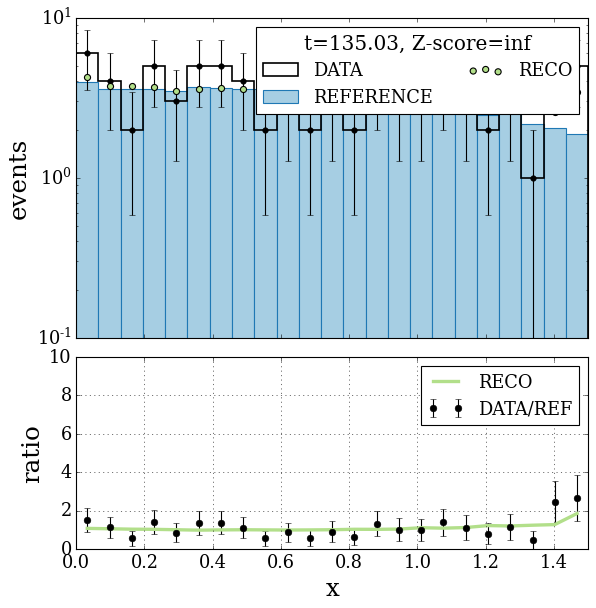

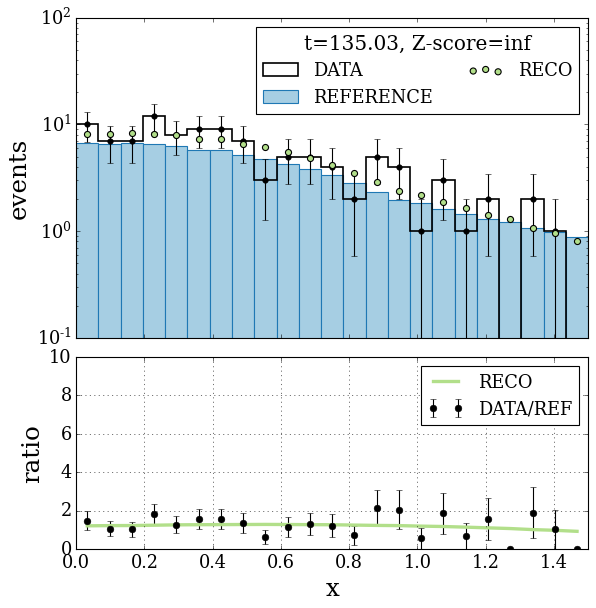

[--] Toy 5: 
[--] Reference shape:(100000, 2)
[--] Data shape:(203, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 74.75289148323452
Time = 266.77 sec
	
[--] Toy 6: 
[--] Reference shape:(100000, 2)
[--] Data shape:(189, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 58.57913286125661
Time = 319.49 sec
	
[--] Toy 7: 
[--] Reference shape:(100000, 2)
[--] Data shape:(199, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 69.35777157816608
Time = 332.33 sec
	
[--] Toy 8: 
[--] Reference shape:(100000, 2)
[--] Data shape:(189, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 93.78004978986534
Time = 356.02 sec
	


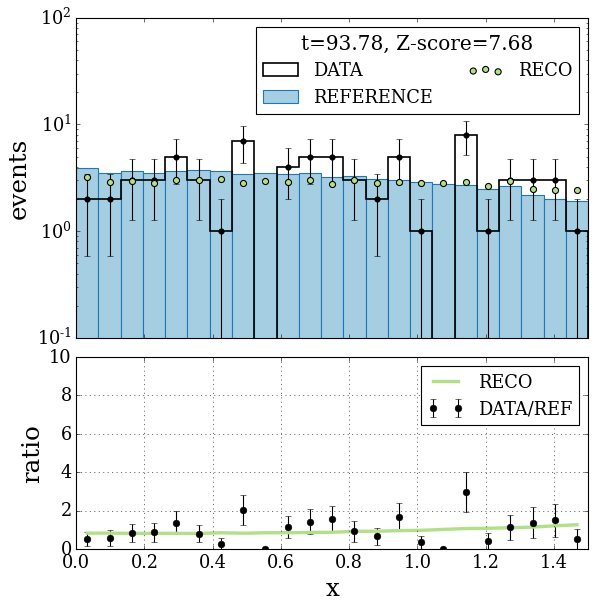

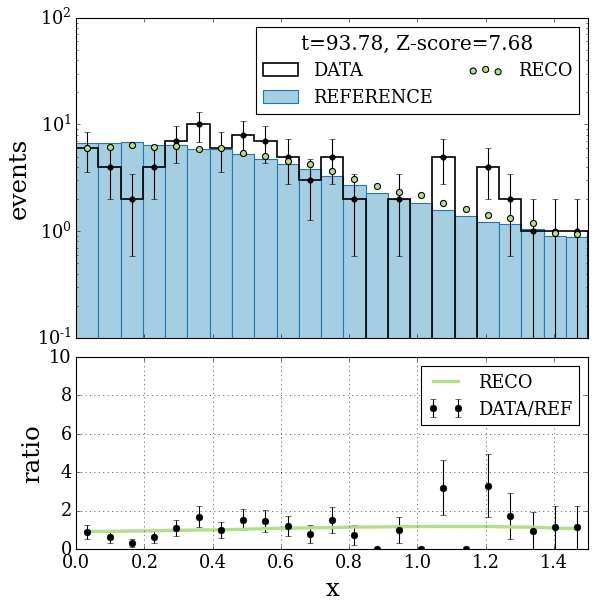

[--] Toy 9: 
[--] Reference shape:(100000, 2)
[--] Data shape:(208, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 85.27218749177763
Time = 326.34 sec
	
[--] Toy 10: 
[--] Reference shape:(100000, 2)
[--] Data shape:(227, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 107.4117485150235
Time = 337.84 sec
	
[--] Toy 11: 
[--] Reference shape:(100000, 2)
[--] Data shape:(174, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 94.9823355762237
Time = 283.73 sec
	
[--] Toy 12: 
[--] Reference shape:(100000, 2)
[--] Data shape:(175, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 63.17632005916443
Time = 289.05 sec
	


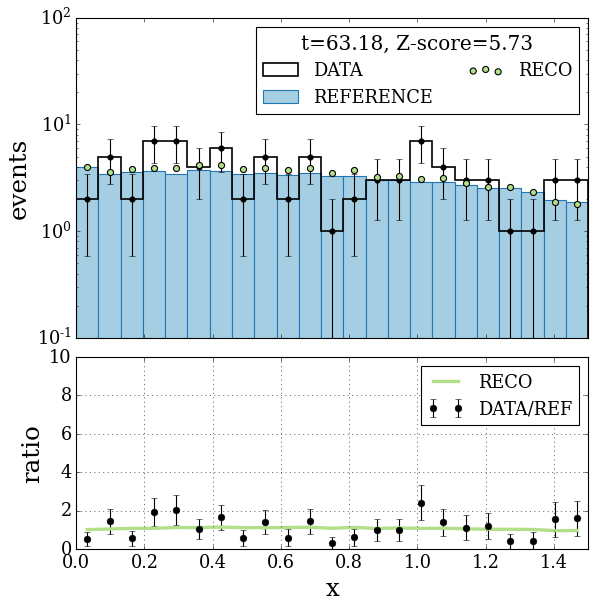

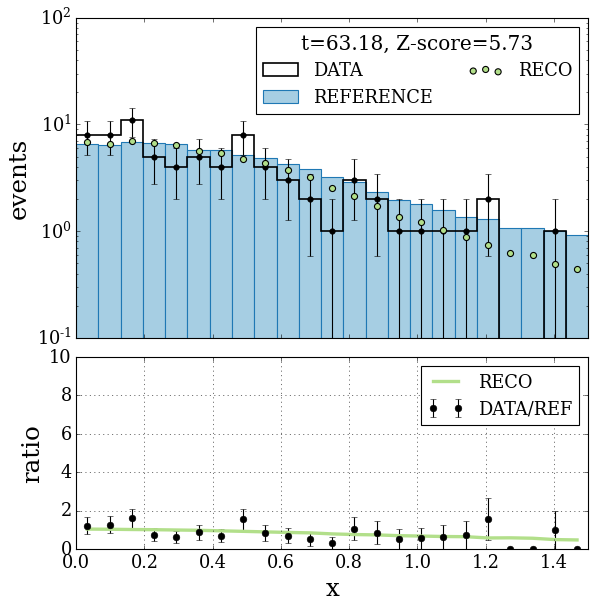

[--] Toy 13: 
[--] Reference shape:(100000, 2)
[--] Data shape:(204, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 74.01322219835015
Time = 276.77 sec
	
[--] Toy 14: 
[--] Reference shape:(100000, 2)
[--] Data shape:(206, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 77.76116129319313
Time = 375.39 sec
	
[--] Toy 15: 
[--] Reference shape:(100000, 2)
[--] Data shape:(195, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 69.66653780323861
Time = 314.9 sec
	
[--] Toy 16: 
[--] Reference shape:(100000, 2)
[--] Data shape:(185, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 60.51416944883449
Time = 231.39 sec
	


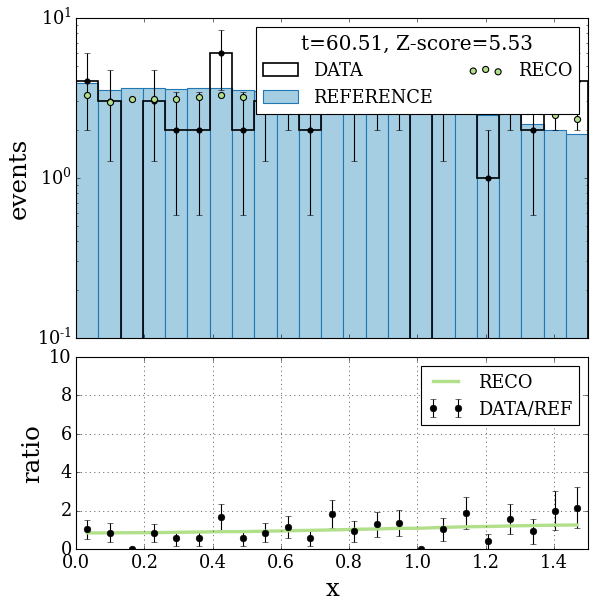

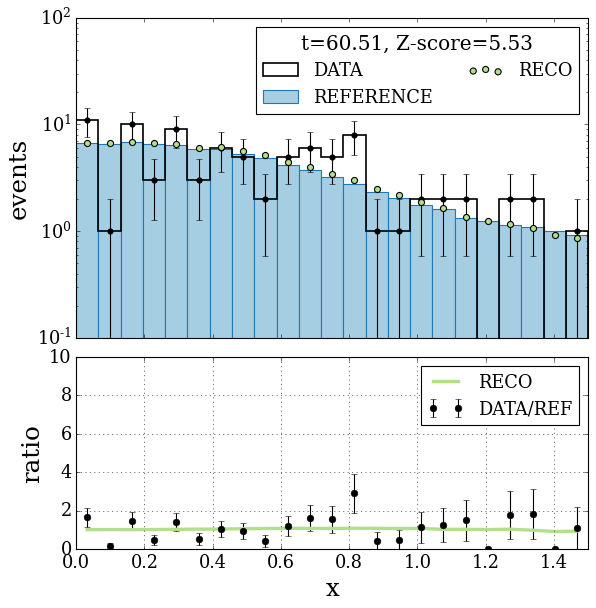

[--] Toy 17: 
[--] Reference shape:(100000, 2)
[--] Data shape:(206, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 62.74936452964194
Time = 341.03 sec
	
[--] Toy 18: 
[--] Reference shape:(100000, 2)
[--] Data shape:(183, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 61.85258097189605
Time = 310.75 sec
	
[--] Toy 19: 
[--] Reference shape:(100000, 2)
[--] Data shape:(184, 2)
Iteration 0 - penalty 1.000000e-10 - sub-iterations 100
t = 70.98361055886036
Time = 306.52 sec
	


In [59]:
N_0=100000 # size of reference sample
N0=170 # expected background
weight=N0/N_0

M=3000
lam=1e-10
flk_sigma = 2.9

flk_config = get_logflk_config(M,flk_sigma,[lam],weight=weight,iter=[100],seed=None,cpu=True) # seed is set inside learn_t function

# null hypothesis
NS= 20 # expected NP component
run_toys("NP1", "drive/MyDrive/CreditCards/creditcard.csv", "./NP1/", N_0, N0, NS, flk_config, toys=np.arange(20), plots_freq= 4, df= best[0])

Iteration 0 - penalty 1.000000e-10 - sub-iterations 100


FileNotFoundError: ignored

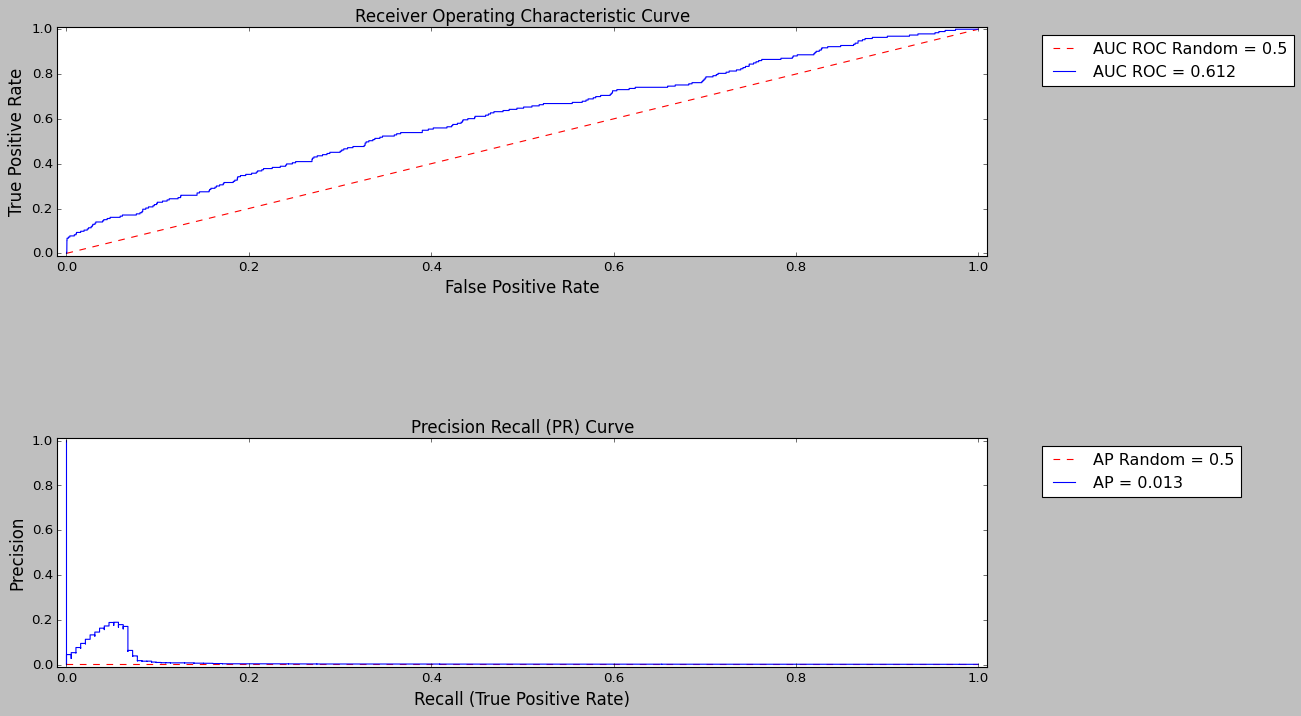

In [60]:
metrics_plots("drive/MyDrive/CreditCards/creditcard.csv", "./fig/", N_0, N0, NS, flk_config, df= best[0])